## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r"D:\New folder\archive (2)\train")
data_dir_test = pathlib.Path(r"D:\New folder\archive (2)\test")

In [8]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

11879
2000


**Data Visualization**

Found 12879 files belonging to 2 classes.


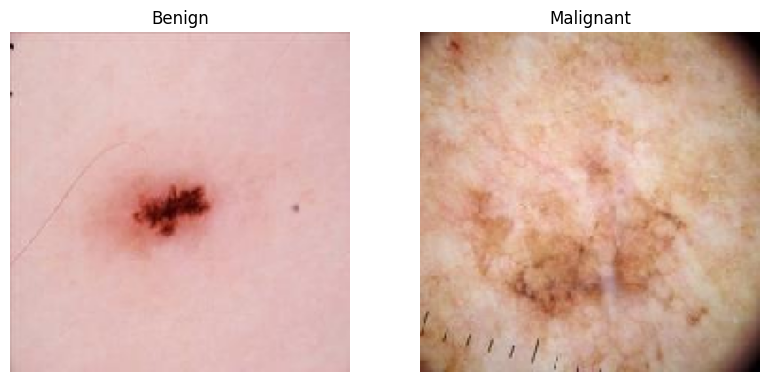

In [3]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [4]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,Benign,6289
1,Malignant,5590


<Axes: xlabel='No. of Image', ylabel='Class'>

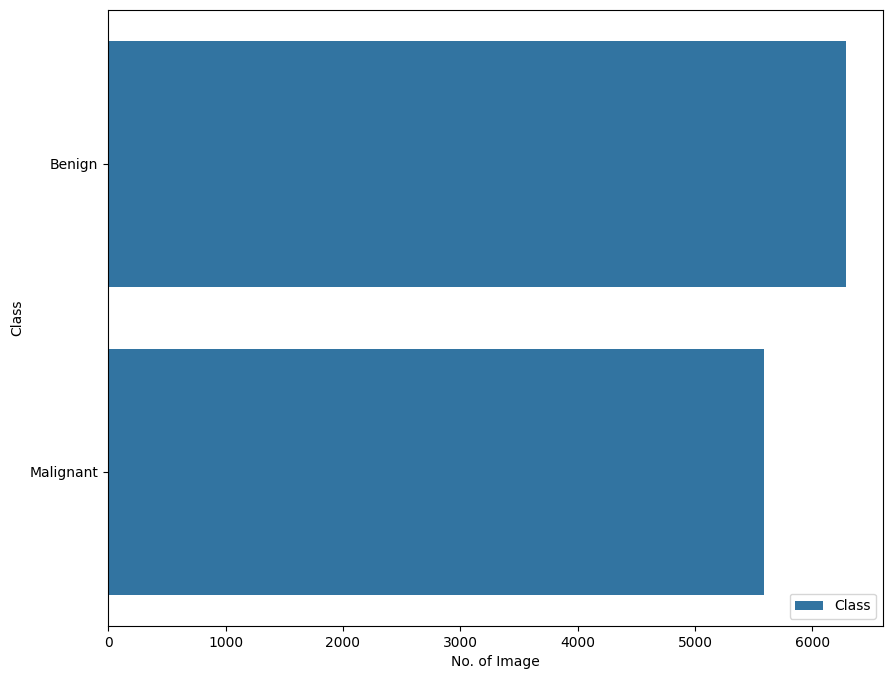

In [11]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [6]:
import os
import Augmentor

# Path to the main training dataset directory
path_to_training_dataset = r'D:\New folder\archive (2)\train'

# Define class names based on actual directory names
class_names = ['Benign', 'Malignant']  # Replace with actual directory names

for class_name in class_names:
    # Construct full path to the class directory
    class_directory = os.path.join(path_to_training_dataset, class_name)

    # Check if the directory exists
    if os.path.exists(class_directory):
        # Create an Augmentor pipeline for the class directory
        p = Augmentor.Pipeline(class_directory)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # Adding 500 samples per class for augmentation
    else:
        print(f"Directory {class_directory} does not exist.")


Initialised with 6289 image(s) found.
Output directory set to D:\New folder\archive (2)\train\Benign\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x2C3659DBE00>: 100%|██████████| 500/500 [00:11<00:00, 43.87 Samples/s]                   


Initialised with 5590 image(s) found.
Output directory set to D:\New folder\archive (2)\train\Malignant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x2C367313500>: 100%|██████████| 500/500 [00:09<00:00, 51.10 Samples/s]                   


In [30]:
import os
import Augmentor

# Path to the main training dataset directory
path_to_training_dataset = r'D:\New folder\archive (2)\train'

# Define class names based on actual directory names
class_names = ['Benign', 'Malignant']  # Replace with actual directory names

for class_name in class_names:
    # Construct full path to the class directory
    class_directory = os.path.join(path_to_training_dataset, class_name)

    # Check if the directory exists
    if os.path.exists(class_directory):
        # Create an Augmentor pipeline for the class directory
        p = Augmentor.Pipeline(class_directory)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)  # Adding 500 samples per class for augmentation
    else:
        print(f"Directory {class_directory} does not exist.")


Initialised with 6289 image(s) found.
Output directory set to D:\New folder\archive (2)\train\Benign\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x159C454F500>: 100%|█| 500/500 [00:03<00:00, 127.97 Samples


Initialised with 5590 image(s) found.
Output directory set to D:\New folder\archive (2)\train\Malignant\output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x159C2C1FE00>: 100%|█| 500/500 [00:03<00:00, 131.12 Samples


In [33]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

1000


**Model Building**

In [34]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=64,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 12879 files belonging to 2 classes.
Using 10304 files for training.


In [35]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=64,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 12879 files belonging to 2 classes.
Using 2575 files for validation.


In [36]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# #CNN Model Architecture



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling

# Define input shape
input_shape = (180, 180, 3)

# Create a Sequential model
model = Sequential()

# Rescaling Layer
model.add(Rescaling(1./255, input_shape=input_shape))

# First Convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# MaxPooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

# Flatten Layer
model.add(Flatten())

# Dense Layer
model.add(Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

# Output Dense Layer with softmax activation function
model.add(Dense(len(class_names), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


C:\Users\shetd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
# checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)


#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [41]:
# Train the model
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7925 - loss: 0.4548
Epoch 1: val_accuracy improved from -inf to 0.85087, saving model to model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.7927 - loss: 0.4545 - val_accuracy: 0.8509 - val_loss: 0.3432
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8339 - loss: 0.3769
Epoch 2: val_accuracy did not improve from 0.85087
161/161 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.8339 - loss: 0.3768 - val_accuracy: 0.8501 - val_loss: 0.3269
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.8467 - loss: 0.3448 
Epoch 3: val_accuracy improved from 0.85087 to 0.85670, saving model to model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 2756s 17s/step - accuracy: 0.8467 - loss: 0.3447 - val_accuracy: 0.8567 - val_loss: 0.3300
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8658 - loss: 0.3209
Epoch 4: val_accuracy improved from 0.85670 to 0.86058, saving model to model.keras
16

In [1]:
# Save the model
# model.save('my_model.h5')
model.save('final_model03.keras')

# Load and evaluate the saved model
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('final_model03.keras')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


NameError: name 'model' is not defined

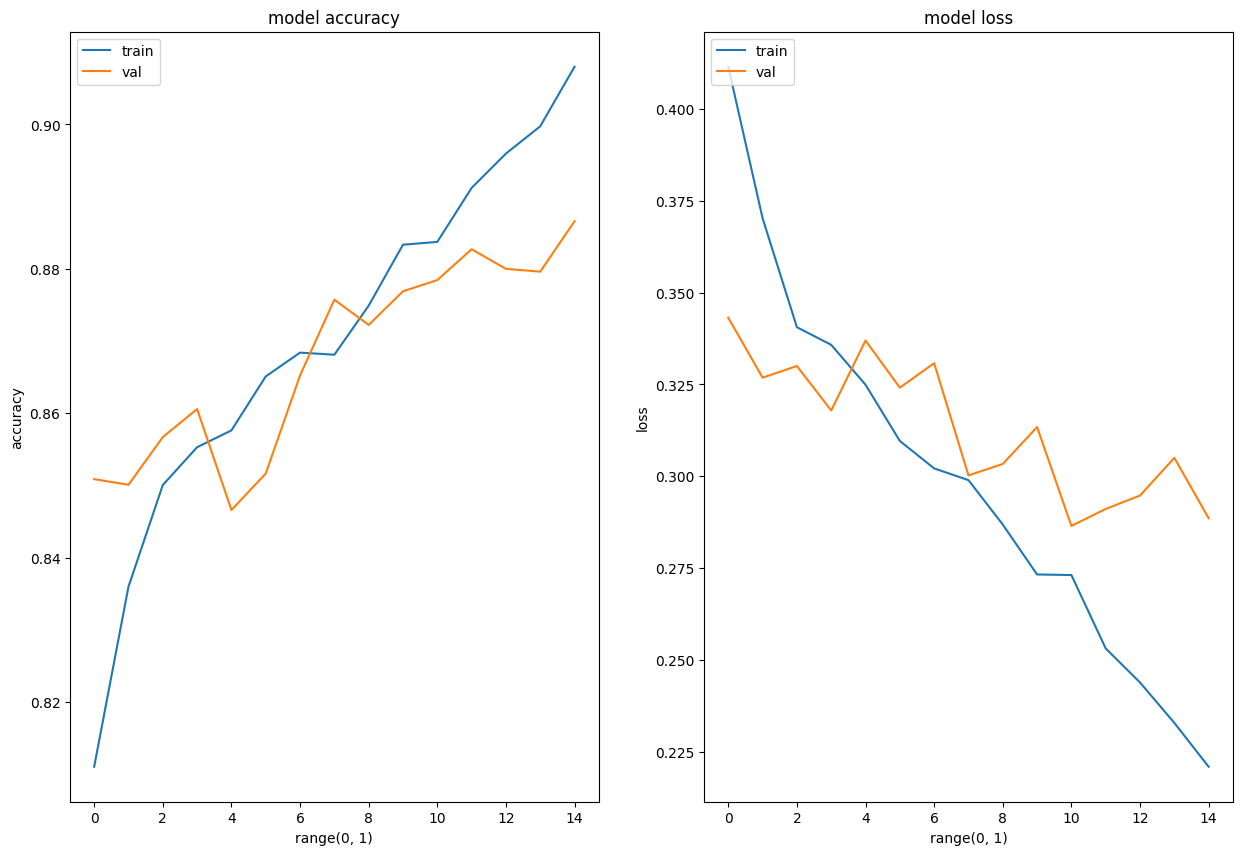

In [49]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from glob import glob
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names and paths
class_names = ['Benign', 'Malignant'] 
data_dir_test = r'D:\New folder\archive (2)\test'  # Replace with the actual path to your test data directory
model_path = r'D:\New folder\my_model.keras'  # Replace with the actual path to your trained model




# Load your trained model
model = load_model(model_path)

true_labels = []
predicted_labels = []

for class_name in class_names:
    test_image_paths = glob(os.path.join(data_dir_test, class_name, '*'))
    print(f"Found {len(test_image_paths)} images for class '{class_name}'")  # Debug statement
    for image_path in test_image_paths:
        try:
            test_image = load_img(image_path, target_size=(180, 180))
            img = img_to_array(test_image)
            img = np.expand_dims(img, axis=0)
            pred = model.predict(img)
            pred_class = np.argmax(pred)
            
            true_labels.append(class_names.index(class_name))
            predicted_labels.append(pred_class)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

# Print out labels for debugging
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Check if true_labels and predicted_labels are non-empty and of the same length
if not true_labels or not predicted_labels:
    raise ValueError("true_labels and predicted_labels must not be empty.")
if len(true_labels) != len(predicted_labels):
    raise ValueError("true_labels and predicted_labels must be of the same length.")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
# report = classification_report(true_labels, predicted_labels, target_names=class_names)
# print(report)


C:\Users\shetd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 1000 images for class 'Benign'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

In [64]:
from glob import glob

correctly_classified = []

for class_name in class_names:
    test_image_paths = glob(os.path.join(data_dir_test, class_name, '*'))
    for image_path in test_image_paths:
        test_image = load_img(image_path, target_size=(180, 180, 3))
        img = np.expand_dims(test_image, axis=0)
        pred = model.predict(img)
        pred = np.argmax(pred)
        if pred == class_names.index(class_name):
            correctly_classified.append((image_path, class_name))

# Now you have a list of correctly classified instances. You can print or process them as needed.
for image_path, class_name in correctly_classified:
    print("Correctly Classified - Image:", image_path, "Predicted Class:", class_name)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━

In [65]:
train_loss,train_accuracy=model.evaluate(train_ds,verbose=0)
print("training accuracy:",train_accuracy)

val_loss,val_accuracy=model.evaluate(val_ds,verbose=0)
print("vallidation accuracy:",val_accuracy)

training accuracy: 0.9256599545478821
vallidation accuracy: 0.8866019248962402


In [66]:
model.save('final_model03.keras')

In [68]:
model.save('final_model03.h5')

In [69]:
# Load the model from Keras format
model_keras = tf.keras.models.load_model('final_model03.keras')

# Load the model from HDF5 format
model_h5 = tf.keras.models.load_model('final_model03.h5')



In [1]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the saved model
new_model = tf.keras.models.load_model('final_model03.keras')

# Define the path to your test images and class names
data_dir_test = r'D:\New folder\archive (2)\test'  # Replace with your actual test data path
class_names = ['Benign', 'Malignant']  # Replace with your actual class names

# Function to display and predict the class of the image
@tf.function(reduce_retracing=True)
def predict_image(img_array):
    predictions = new_model(img_array)
    return predictions

def display_and_predict(image_path):
    # Load and preprocess the image
    Test_image = load_img(image_path, target_size=(180, 180))  # Adjust the target size if needed

    # Display the image
    plt.imshow(Test_image)
    plt.grid(False)
    plt.show()

    # Preprocess the image for prediction
    img_array = img_to_array(Test_image)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input

    # Make predictions using the loaded model
    predictions = predict_image(img_array)
    pred_class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the predicted class
    pred_class = class_names[pred_class_index]  # Get the class name

    # Print the predicted class
    print("Predicted Class: " + pred_class)

# Choose whether to select an image automatically or provide a manual path
manual_image_path = input("Enter the path to the image (leave empty for automatic selection): ").strip()

# Print the manual image path for verification
print(f"Manual image path: '{manual_image_path}'")

if manual_image_path:
    # Use the manually specified image path
    if not os.path.isfile(manual_image_path):
        raise FileNotFoundError(f"The specified image file does not exist: {manual_image_path}")
    display_and_predict(manual_image_path)
else:
    # Ensure the test data directory exists
    if not os.path.isdir(data_dir_test):
        raise FileNotFoundError(f"The specified test data directory does not exist: {data_dir_test}")

    # Load test images
    Test_image_path = os.path.join(data_dir_test, class_names[0], '*')
    test_images = glob(Test_image_path)  # Get list of all test images

    # Check if there are any images
    if not test_images:
        raise FileNotFoundError(f"No images found in the specified directory: {Test_image_path}")

    # Select the fifth image if available, otherwise select the last image
    Test_image = test_images[4] if len(test_images) > 4 else test_images[-1]
    display_and_predict(Test_image)
